In [6]:

import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='aa1227@@$$',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Amaan Ansari/Desktop/programming files/Data science series project/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='aa1227@@$$',
    database='ecommerce'
)
cur = db.cursor()

# 1. List all unique cities where customers are located.

In [56]:
query = """ select distinct customer_city from customers """

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data , columns = ["state"])
df.head(10)

,state
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# 2. Count the number of orders placed in 2017.

In [11]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)
data = cur.fetchall()
data

[(90202,)]

# 3. Find the total sales per category.

In [17]:
query = """ SELECT 
    p.product_category,
    round(SUM(oi.price + oi.freight_value),2) AS total_sales
FROM 
    order_items oi
JOIN 
    products p ON oi.product_id = p.product_id
GROUP BY 
    p.product_category;
 """

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data , columns = ["category" , "sales"])
df.head(10)

,category,sales
0,HEALTH BEAUTY,2882496.14
1,sport leisure,2313312.96
2,Cool Stuff,1438659.90
3,computer accessories,2118544.80
4,Watches present,2611083.22
5,housewares,1556795.54
6,electronics,413650.12
7,None,415410.18
8,toys,1122745.10
9,bed table bath,2483363.44


# 4. Calculate the percentage of orders that were paid in installments.

In [22]:
query = """ SELECT ROUND((SUM(CASE WHEN payment_sequential > 1 THEN 1 ELSE 0 END) / COUNT(DISTINCT order_id)) * 100, 2) AS percentage_paid_in_installment FROM payments; """

cur.execute(query)
data = cur.fetchall()
data

[(Decimal('9.10'),)]

# 5. Count the number of customers from each state.

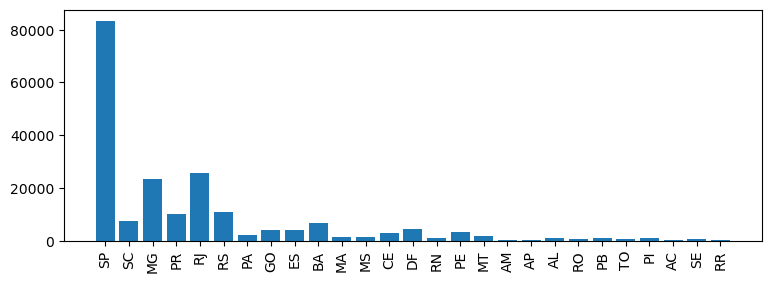

In [37]:
query = """ select customer_state , count(customer_id) from customers group by customer_state; """
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data , columns = ["state" , "customers_count"])
# df

plt.figure(figsize = (9,3))
plt.bar(df["state"] , df["customers_count"])
plt.xticks(rotation = 90)
plt.show()

# 1. Calculate the number of orders per month in 2018.

In [61]:
query = """ 
    select 
        month(order_purchase_timestamp) AS months, 
        count(order_id) AS order_count 
    from 
        orders 
    where 
        year(order_purchase_timestamp) = 2018 
    group by 
        months 
    order by 
        months ASC;
"""

cur.execute(query)
data = cur.fetchall()
data


df = pd.DataFrame(data , columns = ["months" , "order_count"])
df

,months,order_count
0,1,14538
1,2,13456
2,3,14422
3,4,13878
4,5,13746
5,6,12334
6,7,12584
7,8,13024
8,9,32
9,10,8


In [64]:
query = """ with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) avg_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city;
"""

cur.execute(query)
data = cur.fetchall()
data


df = pd.DataFrame(data , columns = ["City_Name" , "Avg_Orders"])
df.head(10)

,City_Name,Avg_Orders
0,treze tilias,2.55
1,indaial,2.23
2,sao jose dos campos,2.28
3,sao paulo,2.31
4,porto alegre,2.35
5,santos,2.32
6,sao francisco do sul,2.47
7,sao vicente,2.18
8,joinville,2.21
9,sao vendelino,2.00


# 3. Calculate the percentage of total revenue contributed by each product category.

In [6]:
query = """ with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) avg_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city;
"""

cur.execute(query)
data = cur.fetchall()
data


df = pd.DataFrame(data , columns = ["City_Name" , "Avg_Orders"])
df.head(10)

,City_Name,Avg_Orders
0,treze tilias,2.55
1,indaial,2.23
2,sao jose dos campos,2.28
3,sao paulo,2.31
4,porto alegre,2.35
5,santos,2.32
6,sao francisco do sul,2.47
7,sao vicente,2.18
8,joinville,2.21
9,sao vendelino,2.00


# Calculate the percentage of total revenue contributed by each product category.

In [7]:
query = """ select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value)from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc;
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data , columns = ["category" , "percentage distribution"])
df.head()


,category,percentage distribution
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86


# Identify the correlation between product price and the number of times a product has been purchased.

In [14]:
import numpy as np

query = """ select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items 
on products.product_id = order_items.product_id
group by products.product_category;
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data , columns = ["category" , "order_count" , "price"])
df.head(10)

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1 , arr2])
print("the correlation between product prize and number of times products are purchased is" , a[0][1])

the correlation between product prize and number of times products are purchased is -0.10631514167157564


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

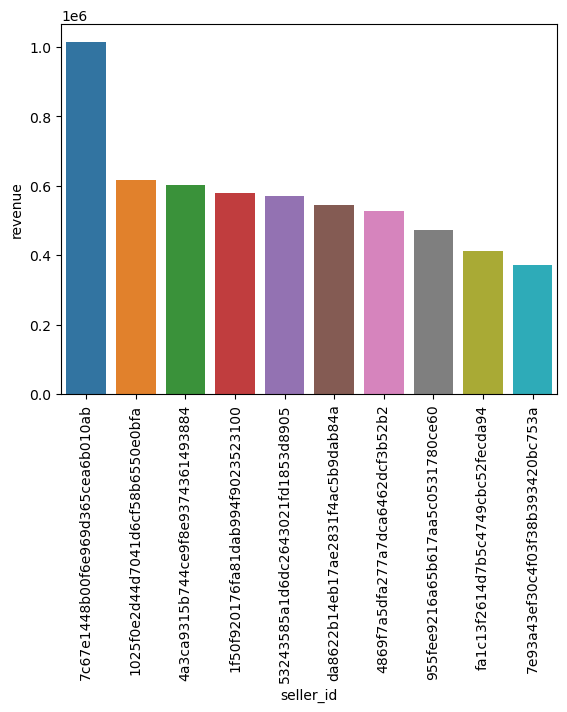

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
query = """ SELECT *, 
       DENSE_RANK() OVER(ORDER BY revenue DESC) AS rn
FROM (
    SELECT order_items.seller_id, 
           ROUND(SUM(payments.payment_value), 2) AS revenue
    FROM order_items
    JOIN payments ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
) AS a;

"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data , columns = ["seller_id" , "revenue" , "rank"])
df = df.head(10)
sns.barplot(x = "seller_id" , y = "revenue" , data = df)
plt.xticks(rotation = 90)
plt.show()